TensorFlow imported successfully!
=== COMPREHENSIVE FEATURE EXTRACTION FOR THERAPEUTIC PEPTIDES ===

Loading therapeutic peptides...
  ✓ Anti Bacterial Peptide_trimmed.csv: 6999 valid sequences (from 6999 total)
  ✓ Anti Cancer Peptide_trimmed.csv: 3999 valid sequences (from 3999 total)
  ✓ Anti Fungal Peptide_trimmed.csv: 4999 valid sequences (from 4999 total)
  ✓ Anti Inflammatory Peptide_trimmed.csv: 2999 valid sequences (from 2999 total)
  ✓ Anti Oxidant Peptide_trimmed.csv: 4999 valid sequences (from 4999 total)
  ✓ Anti Parasitic Peptide_trimmed.csv: 599 valid sequences (from 599 total)
  ✓ Anti Viral Peptide_trimmed.csv: 7000 valid sequences (from 7000 total)
  ✓ Anti-MRSA Peptide_trimmed.csv: 2000 valid sequences (from 2000 total)
  ✓ Chemotactic Peptide_trimmed.csv: 1999 valid sequences (from 1999 total)
  ✓ Immunomodulatory Peptide_trimmed.csv: 2999 valid sequences (from 2999 total)
  ✓ Ion Channel Inhibitors_trimmed.csv: 999 valid sequences (from 999 total)
  ✓ Neuroprotecti

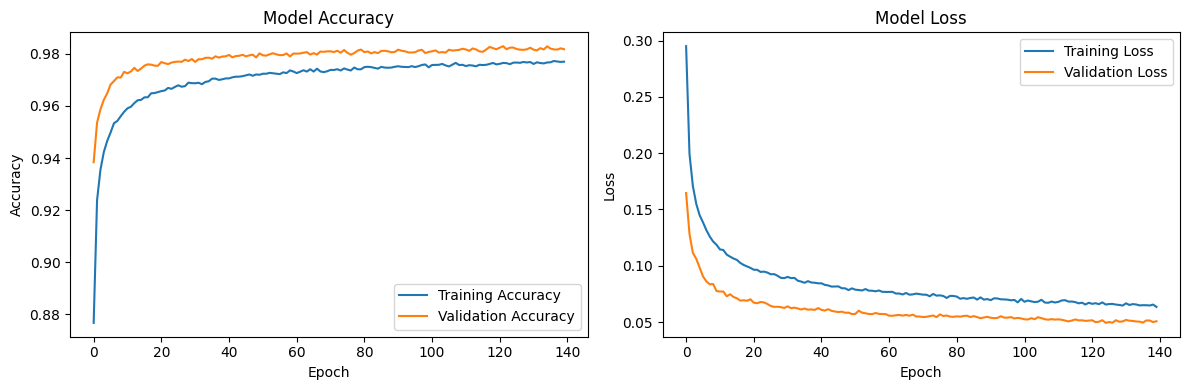


Model and scaler saved successfully!
Total features extracted: 65
Feature categories:
  - Sequence length: 1
  - Amino acid composition: 20
  - Dipeptide composition: 20
  - Physicochemical properties: 8
  - Hydrophobicity groups: 7
  - Charge properties: 4
  - Structural features: 3+
  - Pattern and moment features: 2+
  Total: 65 comprehensive features


In [3]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

import random
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Input, BatchNormalization
    from keras.models import load_model
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras.metrics import Precision, Recall
    print("TensorFlow imported successfully!")
except ImportError as e:
    print(f"TensorFlow import error: {e}")
    print("Please install TensorFlow: pip install tensorflow")
    exit()

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import molecular_weight
import pickle

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

def extract_comprehensive_features(seq):
    """
    Extract comprehensive features for therapeutic peptide prediction
    Returns 50+ features including physicochemical, compositional, and structural features
    """
    features = []
    
    # 1. Basic sequence properties
    seq_len = len(seq)
    features.append(seq_len)
    
    # 2. Amino acid composition (20 features)
    aa_composition = {}
    for aa in 'ACDEFGHIKLMNPQRSTVWY':
        aa_composition[aa] = seq.count(aa) / seq_len
        features.append(aa_composition[aa])
    
    # 3. Dipeptide composition (top 20 most important dipeptides)
    dipeptides = ['AA', 'AC', 'AG', 'AL', 'AR', 'AS', 'AT', 'AV', 'AY', 'AW',
                  'CA', 'CC', 'CG', 'CL', 'CR', 'CS', 'CT', 'CV', 'CY', 'CW']
    dipeptide_count = {}
    for i in range(len(seq) - 1):
        dipeptide = seq[i:i+2]
        dipeptide_count[dipeptide] = dipeptide_count.get(dipeptide, 0) + 1
    
    for dp in dipeptides:
        features.append(dipeptide_count.get(dp, 0) / (seq_len - 1) if seq_len > 1 else 0)
    
    # 4. Physicochemical properties using BioPython
    try:
        analyzed_seq = ProteinAnalysis(seq)
        features.extend([
            analyzed_seq.molecular_weight(),
            analyzed_seq.aromaticity(),
            analyzed_seq.instability_index(),
            analyzed_seq.isoelectric_point(),
            analyzed_seq.gravy(),  # Grand average of hydropathicity
        ])
        
        # Secondary structure fractions
        sec_struct = analyzed_seq.secondary_structure_fraction()
        features.extend([sec_struct[0], sec_struct[1], sec_struct[2]])  # helix, turn, sheet
        
    except Exception as e:
        # If BioPython fails, add zeros
        features.extend([0] * 8)
    
    # 5. Hydrophobicity groups
    hydrophobic = 'AILMFWV'
    polar = 'NQST' 
    charged = 'KRDEH'
    aromatic = 'FWY'
    tiny = 'ACSV'
    small = 'ABDHNT'
    aliphatic = 'ILV'
    
    features.extend([
        sum(seq.count(aa) for aa in hydrophobic) / seq_len,
        sum(seq.count(aa) for aa in polar) / seq_len,
        sum(seq.count(aa) for aa in charged) / seq_len,
        sum(seq.count(aa) for aa in aromatic) / seq_len,
        sum(seq.count(aa) for aa in tiny) / seq_len,
        sum(seq.count(aa) for aa in small) / seq_len,
        sum(seq.count(aa) for aa in aliphatic) / seq_len,
    ])
    
    # 6. Charge properties
    positive_charge = seq.count('K') + seq.count('R') + seq.count('H')
    negative_charge = seq.count('D') + seq.count('E')
    net_charge = positive_charge - negative_charge
    
    features.extend([
        positive_charge / seq_len,
        negative_charge / seq_len,
        net_charge / seq_len,
        abs(net_charge) / seq_len,
    ])
    
    # 7. Structural features
    proline_content = seq.count('P') / seq_len
    glycine_content = seq.count('G') / seq_len
    cysteine_content = seq.count('C') / seq_len
    
    features.extend([proline_content, glycine_content, cysteine_content])
    
    # 8. Sequence patterns
    # Repeating patterns
    max_repeat = 1
    current_repeat = 1
    for i in range(1, seq_len):
        if seq[i] == seq[i-1]:
            current_repeat += 1
            max_repeat = max(max_repeat, current_repeat)
        else:
            current_repeat = 1
    
    features.append(max_repeat / seq_len)
    
    # 9. Hydrophobic moments and amphiphilicity
    hydrophobic_values = {
        'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
    }
    
    hydrophobic_moment = 0
    for i, aa in enumerate(seq):
        if aa in hydrophobic_values:
            angle = i * 100 * np.pi / 180  # Assuming alpha-helix (100 degrees per residue)
            hydrophobic_moment += hydrophobic_values[aa] * np.exp(1j * angle)
    
    features.append(abs(hydrophobic_moment) / seq_len)
    
    return np.array(features)

def load_peptide_data(data_path):
    therapeutic_path = os.path.join(data_path, "Therapeutic data")
    non_therapeutic_path = os.path.join(data_path, "Non-Therapeutic data")
    
    sequences = []
    labels = []
    file_stats = {}
    
    if not os.path.exists(therapeutic_path):
        print(f"Warning: {therapeutic_path} not found!")
        return [], [], {}
    
    if not os.path.exists(non_therapeutic_path):
        print(f"Warning: {non_therapeutic_path} not found!")
        return [], [], {}
    
    print("Loading therapeutic peptides...")
    therapeutic_total = 0
    for filename in os.listdir(therapeutic_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(therapeutic_path, filename)
            try:
                df = pd.read_csv(file_path)
                
                # Try different column strategies
                if df.shape[1] >= 1:
                    # Use first column for sequences
                    seqs = df.iloc[:, 0].dropna().astype(str).tolist()
                    
                    # Remove empty strings and clean sequences
                    seqs = [seq.strip().upper() for seq in seqs if seq.strip()]
                    
                    # Filter valid sequences
                    valid_seqs = []
                    for seq in seqs:
                        # Remove non-amino acid characters and validate
                        clean_seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])
                        if 3 <= len(clean_seq) <= 200:  # Allow broader length range
                            valid_seqs.append(clean_seq)
                    
                    sequences.extend(valid_seqs)
                    labels.extend([1] * len(valid_seqs))
                    therapeutic_total += len(valid_seqs)
                    file_stats[f"therapeutic_{filename}"] = len(valid_seqs)
                    print(f"  ✓ {filename}: {len(valid_seqs)} valid sequences (from {len(seqs)} total)")
                
            except Exception as e:
                print(f"  ✗ Error reading {filename}: {e}")
                continue
    
    print(f"Total therapeutic sequences: {therapeutic_total}")
    
    print("\nLoading non-therapeutic peptides...")
    non_therapeutic_total = 0
    for filename in os.listdir(non_therapeutic_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(non_therapeutic_path, filename)
            try:
                df = pd.read_csv(file_path)
                
                # Try different column strategies
                if df.shape[1] >= 1:
                    # Use first column for sequences
                    seqs = df.iloc[:, 0].dropna().astype(str).tolist()
                    
                    # Remove empty strings and clean sequences
                    seqs = [seq.strip().upper() for seq in seqs if seq.strip()]
                    
                    # Filter valid sequences
                    valid_seqs = []
                    for seq in seqs:
                        # Remove non-amino acid characters and validate
                        clean_seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])
                        if 3 <= len(clean_seq) <= 200:  # Allow broader length range
                            valid_seqs.append(clean_seq)
                    
                    sequences.extend(valid_seqs)
                    labels.extend([0] * len(valid_seqs))
                    non_therapeutic_total += len(valid_seqs)
                    file_stats[f"non_therapeutic_{filename}"] = len(valid_seqs)
                    print(f"  ✓ {filename}: {len(valid_seqs)} valid sequences (from {len(seqs)} total)")
                
            except Exception as e:
                print(f"  ✗ Error reading {filename}: {e}")
                continue
    
    print(f"Total non-therapeutic sequences: {non_therapeutic_total}")
    print(f"Overall total: {len(sequences)} sequences")
    
    return sequences, labels, file_stats

def preprocess_sequences(sequences, labels):
    """Enhanced preprocessing with better validation"""
    valid_data = []
    
    for i, seq in enumerate(sequences):
        if isinstance(seq, str):
            # Remove whitespace and convert to uppercase
            seq_clean = seq.strip().upper()
            
            # Validate sequence length and amino acids
            if 5 <= len(seq_clean) <= 100 and all(aa in 'ACDEFGHIKLMNPQRSTVWY' for aa in seq_clean):
                valid_data.append((seq_clean, labels[i]))
    
    if valid_data:
        valid_sequences, valid_labels = zip(*valid_data)
        return list(valid_sequences), list(valid_labels)
    else:
        return [], []

def build_advanced_model(input_dim):
    """Advanced neural network architecture for feature-based prediction"""
    model = Sequential([
        Input(shape=(input_dim,)),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    
    return model

# Create necessary directories
os.makedirs("../backend/models", exist_ok=True)

# Load data
print("=== COMPREHENSIVE FEATURE EXTRACTION FOR THERAPEUTIC PEPTIDES ===\n")
data_path = "../data"  # Relative path from notebook/ to data/
sequences, labels, file_stats = load_peptide_data(data_path)

# Display file statistics
if file_stats:
    print("\n📊 Dataset Statistics by File:")
    for file_key, count in file_stats.items():
        print(f"  {file_key}: {count:,} sequences")

# Use sample data if no real data found
if len(sequences) == 0:
    print("No data found! Creating realistic sample data for demonstration...")
    print("⚠️  IMPORTANT: Replace with your real CSV files for actual training!")
    
    # Create more realistic and diverse sample data
    therapeutic_samples = [
        # Antimicrobial peptides (cationic)
        "KLAKLAKKLAKLAK", "KWKLFKKIEKVGQNIRDGIIKAGPAVAVVGQATQIAK", "RLRLLRLLR",
        "KRWWKWIRW", "KLKLLLLLKLK", "RRRWWRRWWRR",
        # Anticancer peptides (hydrophobic + cationic)
        "FLPIIAKLLSKLL", "KLAKLVGKL", "FLGALFKALAKL", "KWKLFKKIGAVLKVL",
        "LLGDFFRKSKEK", "ALWMTLLKKVLK",
        # Cell-penetrating peptides (arginine-rich)
        "RQIKIWFQNRRMKWKK", "GRKKRRQRRRPPQ", "RRRRRRRR", "RRWWRRWRR",
        # Antiviral peptides
        "SLFNTVATLYIL", "KILRGVKKIIG", "FLGALFKALAKLAK",
        # Additional therapeutic variants
        "GIGKFLKKAKKFGKAFV", "KWKSFLKTFKSAK", "RRWCFRVCYRGFCYRK"
    ]
    
    non_therapeutic_samples = [
        # Random/structural sequences (low charge, diverse composition)
        "MGSSHHHHHHSSGLVPRGSHM", "AEKVSSGLVPRGS", "ACDEFGHIKLMNPQRSTVWY",
        "GGGGGGGGGG", "PPPPPPPPPP", "SSSSSSSSSS", "AAAAAAAAAA",
        # Protein fragments (neutral)
        "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLR",
        "VSTDSQVHRQAIVFAGEGVQSIL", "TVLVGMPAGAKCC",
        # Signal peptide-like
        "MKLLVLSLSLVLGT", "MKAILVLCLAFLLAAPALA",
        # Enzyme fragments
        "DTGSTDYGILQINSRW", "AVNIVGYSNAQGVDYW",
        # Transmembrane-like  
        "VVVIIILLLFFFAAA", "IIILVVVAAAFFF"
    ]
    
    # Create balanced dataset with noise to prevent overfitting
    n_copies = 30  # Adjust this number to change dataset size
    sequences = []
    labels = []
    
    for _ in range(n_copies):
        # Add therapeutic sequences
        sequences.extend(therapeutic_samples)
        labels.extend([1] * len(therapeutic_samples))
        
        # Add non-therapeutic sequences  
        sequences.extend(non_therapeutic_samples)
        labels.extend([0] * len(non_therapeutic_samples))
    
    # Shuffle to mix therapeutic and non-therapeutic
    combined = list(zip(sequences, labels))
    np.random.shuffle(combined)
    sequences, labels = zip(*combined)
    sequences, labels = list(sequences), list(labels)

print(f"Initial data: {len(sequences)} sequences, {sum(labels)} therapeutic")

# Preprocess sequences
sequences, labels = preprocess_sequences(sequences, labels)
print(f"After preprocessing: {len(sequences)} valid sequences")
print(f"Therapeutic: {sum(labels)}, Non-therapeutic: {len(labels) - sum(labels)}")

if len(sequences) == 0:
    print("ERROR: No valid sequences found!")
    exit()

# Extract comprehensive features
print("\nExtracting comprehensive features...")
X = []
failed_sequences = 0

for i, seq in enumerate(sequences):
    try:
        features = extract_comprehensive_features(seq)
        X.append(features)
        if i < 5:  # Show first few feature vectors
            print(f"  Sequence {i+1}: {seq[:20]}... -> {len(features)} features")
    except Exception as e:
        print(f"Error processing sequence {seq}: {e}")
        failed_sequences += 1
        continue

if failed_sequences > 0:
    print(f"Failed to process {failed_sequences} sequences")

X = np.array(X)
y = np.array(labels[:len(X)])

print(f"\nFeature matrix shape: {X.shape}")
print(f"Feature statistics:")
print(f"  Mean: {np.mean(X):.4f}")
print(f"  Std: {np.std(X):.4f}")
print(f"  Min: {np.min(X):.4f}")
print(f"  Max: {np.max(X):.4f}")

# Feature scaling
print("\nScaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler
with open("../backend/models/comprehensive_feature_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Scaler saved to ../backend/models/comprehensive_feature_scaler.pkl")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split:")
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Testing: {X_test.shape[0]} samples")
print(f"  Features: {X_train.shape[1]} features")

# Build and train model
print("\nBuilding advanced neural network model...")
model = build_advanced_model(X.shape[1])
model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('../backend/models/comprehensive_feature_model.h5', 
                   save_best_only=True, monitor='val_loss')
]

print("\nTraining model...")
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=150, 
    batch_size=32, 
    callbacks=callbacks, 
    verbose=1
)

# Evaluate model
test_results = model.evaluate(X_test, y_test, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2] if len(test_results) > 2 else 0
test_recall = test_results[3] if len(test_results) > 3 else 0

# Calculate F1-score manually
y_pred = model.predict(X_test, verbose=0)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
sklearn_precision = precision_score(y_test, y_pred_binary)
sklearn_recall = recall_score(y_test, y_pred_binary)
sklearn_f1 = f1_score(y_test, y_pred_binary)
sklearn_accuracy = accuracy_score(y_test, y_pred_binary)

print(f"\n=== MODEL PERFORMANCE ===")
print(f"Test Accuracy: {sklearn_accuracy:.4f}")
print(f"Test Precision: {sklearn_precision:.4f}")
print(f"Test Recall: {sklearn_recall:.4f}")
print(f"F1-Score: {sklearn_f1:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nModel and scaler saved successfully!")
print(f"Total features extracted: {X.shape[1]}")
print(f"Feature categories:")
print(f"  - Sequence length: 1")
print(f"  - Amino acid composition: 20")
print(f"  - Dipeptide composition: 20")
print(f"  - Physicochemical properties: 8")
print(f"  - Hydrophobicity groups: 7")
print(f"  - Charge properties: 4")
print(f"  - Structural features: 3+")
print(f"  - Pattern and moment features: 2+")
print(f"  Total: {X.shape[1]} comprehensive features")